In [5]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
import torch.nn.functional as F
import time
import sys
import torch.utils.data as data
from torch.utils.data import DataLoader,Dataset
import cv2


In [6]:
import albumentations as ALB
from albumentations.pytorch.transforms import ToTensor

Faster RCNN with resnet50 backbone and FPN




In [7]:
# pre-trained on COCO
my_net=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [8]:
# 21 classes for VOC
my_net.roi_heads.box_predictor.cls_score.out_features=21

In [9]:
#textfile for label classes and indexes

!git clone https://github.com/amikelive/coco-labels.git

Cloning into 'coco-labels'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 36 (delta 2), reused 9 (delta 2), pack-reused 25
Unpacking objects: 100% (36/36), done.


In [10]:
# Dictionaries to obtain mapping between index label to class and vice versa

with open("/content/coco-labels/coco-labels-paper.txt","r") as f:
  i=1
  cls_to_idx={}
  idx_to_cls={}
  for line in f:
    line=line.rstrip()
    # naming in coco and voc is different for the same object
    if line=="motorcycle":
      line="motorbike"
    if line=="couch":
      line="sofa"
    if line=="airplane":
      line="aeroplane"
    if line=="potted plant":
      line="pottedplant"
    if line=="tv":
      line="tvmonitor"
    if line=="dining table":
      line="diningtable"
      
    cls_to_idx[line]=i
    idx_to_cls[i]=line
    i+=1

    

In [11]:
VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

In [12]:
#to obtain the indexes that belongs to VOC 
VOC_INDEX=[]
for label in VOC_CLASSES:
  VOC_INDEX.append(cls_to_idx[label])


Preparing the data

In [ ]:
torchvision.datasets.VOCDetection(root="/content",year="2012",image_set="train",download=True)

In [15]:
torchvision.datasets.VOCDetection(root="/content",year="2007",image_set="train",download=True)

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /content

In [ ]:
!tar -xvf "VOCtrainval_11-May-2012.tar"

In [ ]:
!tar -xvf "VOCtrainval_06-Nov-2007.tar"

In [17]:
test_transform=ALB.Compose([ALB.pytorch.transforms.ToTensor()])

In [18]:
import pickle
import xml
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [21]:
# to get all the image ids in the test set
ids=[]

#for VOC2012,
for line in open(os.path.join("/content/VOCdevkit/VOC2012/"+"ImageSets","Main",
                              "val"+".txt")):
    ids.append(line.strip())

#for VOC2007
"""
for line in open(os.path.join("/content/VOCdevkit/VOC2007/"+"ImageSets","Main",
                              "val"+".txt")):
    ids.append(line.strip())
"""

In [50]:
class VocDataset(Dataset):
  def __init__(self,set,year,transforms=None):
    self.transforms=transforms
    self.set=set
    self.ids=[]

    if year=="2012":
      #For VOC2012
      self.anno_path="/content/VOCdevkit/VOC2012/Annotations/"
      self.img_path="/content/VOCdevkit/VOC2012/JPEGImages/"
      self.year=year
      rootpath="/content/VOCdevkit/VOC2012/"

    if year=="2007":
      self.anno_path="/content/VOCdevkit/VOC2007/Annotations/"
      self.img_path="/content/VOCdevkit/VOC2007/JPEGImages/"
      rootpath="/content/VOCdevkit/VOC2007/"


    for line in open(os.path.join(rootpath+"ImageSets","Main",self.set+".txt")):
      self.ids.append(line.strip())

  def __getitem__(self,index):
    img_id=self.ids[index]

    target=ET.parse(os.path.join(self.anno_path + img_id+".xml")).getroot()
    img=cv2.imread(os.path.join(self.img_path  +img_id+ ".jpg"),cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    height,width,channels=img.shape

    #transform the annotations
    result=[]
    for obj in target.iter('object'):
      difficult=int(obj.find('difficult').text)==1 #num of difficult
      if difficult: #dont keep the difficult examples
        continue
      name=obj.find('name').text.lower().strip()
      bbox=obj.find('bndbox')
      
      pts=['xmin','ymin','xmax','ymax']
      bndbox=[]
      for i,pt in enumerate(pts):
        cur_pt=int(bbox.find(pt).text)-1
        bndbox.append(cur_pt)
      label_idx=cls_to_idx[name]
      bndbox.append(label_idx)
      result.append(bndbox)
    target=result
      

    #transform the image
    if self.transforms is not None:
      target=np.array(target)
      input={'image':img,
             'bboxes':target[:,:4],
             'labels':target[:,4]}
      output=self.transforms(**input)
      img,boxes,labels=output['image'],output['bboxes'],output['labels']


      boxes=torch.stack(tuple(map(torch.tensor, zip(*boxes)))).permute(1, 0)
      target={}
      target['boxes']=boxes
      target['labels']=torch.tensor(np.expand_dims(labels,axis=1))

    return [img,target,height,width,result]

  def get(self,index):
    img_id=self.ids[index]

    target=ET.parse(os.path.join(self.anno_path + img_id+".xml")).getroot()
    img=cv2.imread(os.path.join(self.img_path  +img_id+ ".jpg"),cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    height,width,channels=img.shape

    #transform the annotations
    result=[]
    for obj in target.iter('object'):
      difficult=int(obj.find('difficult').text)==1 #num of difficult
      if difficult: #dont keep the difficult examples
        continue
      name=obj.find('name').text.lower().strip()
      bbox=obj.find('bndbox')
      
      pts=['xmin','ymin','xmax','ymax']
      bndbox=[]
      for i,pt in enumerate(pts):
        cur_pt=int(bbox.find(pt).text)-1
        bndbox.append(cur_pt)
      label_idx=cls_to_idx[name]
      bndbox.append(label_idx)
      result.append(bndbox)
    target=result
      

    #transform the image
    if self.transforms is not None:
      target=np.array(target)
      input={'image':img,
             'bboxes':target[:,:4],
             'labels':target[:,4]}
      output=self.transforms(**input)
      img,boxes,labels=output['image'],output['bboxes'],output['labels']

      boxes=torch.stack(tuple(map(torch.tensor, zip(*boxes)))).permute(1, 0)
      target={}
      target['boxes']=boxes
      target['labels']=torch.tensor(np.expand_dims(labels,axis=1))

    return [img,target,height,width,result]

  def __len__(self):
    return len(self.ids)

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [51]:
val_set=VocDataset("val","2012",transforms=test_transform)

In [52]:
val_loader=DataLoader(val_set,batch_size=4,shuffle=False,num_workers=4,collate_fn=collate_fn)

Evaluating the model

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Functions for evaluation

import pickle

def parse_rec(filename):
  """ Parse a PASCAL VOC xml file """
  tree = ET.parse(filename)
  objects = []
  for obj in tree.findall('object'):
    obj_struct = {}
    obj_struct['name'] = obj.find('name').text
    obj_struct['pose'] = obj.find('pose').text
    obj_struct['truncated'] = int(obj.find('truncated').text)
    obj_struct['difficult'] = int(obj.find('difficult').text)
    bbox = obj.find('bndbox')
    obj_struct['bbox'] = [int(bbox.find('xmin').text),
                          int(bbox.find('ymin').text),
                          int(bbox.find('xmax').text),
                          int(bbox.find('ymax').text)]
    objects.append(obj_struct)

  return objects

def get_output_dir(name,phase):
    """Returns the dir where expt artifacts are placed.
    if dir does not exist, will be created
    a canonical path will be built using the name from an imdb and a network(if not none)
    """
    filedir=os.path.join(name,phase)
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    return filedir

def get_voc_results_file_template(image_set,cls):
    #VOCdevkit/VOC2007/results/det_test_aeroplane.txt
    filename='det_' + image_set+'_%s.txt' %(cls)
    filedir=os.path.join(devkit_path,'results')
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    path=os.path.join(filedir,filename)
    return path

def write_voc_results_file(all_boxes,dataset):
    for cls_ind,cls in enumerate(cls_to_idx):
        if cls_ind+1 in VOC_INDEX:
          print('Writing {:s} VOC results file'.format(cls))
          filename=get_voc_results_file_template("test",cls)
          cls_ind=VOC_INDEX.index(cls_ind+1)
          with open(filename,'wt') as f:
            for im_ind,index in enumerate(dataset.ids):
              dets=all_boxes[cls_ind][im_ind] #get the bbox info at the current class and current image
              if dets==[]:
                continue
              #vocdevkit expects 1-based indices
              for k in range(dets.shape[0]):
                  f.write('{:s} {:3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.format(
                        index, dets[k,-1], dets[k,0]+1, dets[k,1] +1,
                        dets[k,2]+1,dets[k,3]+1 ))
            
def do_python_eval(output_dir='output',use_07=True):
    cachedir=os.path.join(devkit_path,'annotations_cache')
    aps=[]
    # pascal voc metric changed in 2010
    use_07_metric=use_07
    print('VOC07 metric?' + ('Yes' if use_07_metric else 'No'))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    for i,cls in enumerate(cls_to_idx):
        if i+1 not in VOC_INDEX:
          continue

        filename=get_voc_results_file_template("test",cls)

        """
        for evaluation on 2012 dataset:

        rec,prec,ap=voc_eval(
            filename,anno_path,img_set_path.format("val"),cls,cachedir,
            ovthresh=0.5,use_07_metric=use_07_metric)
        """

        rec,prec,ap=voc_eval(
            filename,anno_path,img_set_path.format("val"),cls,cachedir,
            ovthresh=0.5,use_07_metric=use_07_metric)
        aps+=[ap]
        print('AP for {}={:.4f}'.format(cls,ap))
        #print('Recall for {}={:.4f}'.format(cls,int(rec)))
        #print('Precision for {}={:.4f}'.format(cls,int(prec)))
        with open(os.path.join(output_dir,cls+'_pr.pkl'),'wb') as f:
            pickle.dump({'rec':rec,'prec':prec,'ap':ap},f)
    print('Mean AP={:.4f}'.format(np.mean(aps)))

def voc_ap(rec, prec, use_07_metric=False):
  """ ap = voc_ap(rec, prec, [use_07_metric])
  Compute VOC AP given precision and recall.
  If use_07_metric is true, uses the
  VOC 07 11 point method (default:False).
  """
  if use_07_metric:
    # 11 point metric
    ap = 0.
    for t in np.arange(0., 1.1, 0.1):
      if np.sum(rec >= t) == 0:
        p = 0
      else:
        p = np.max(prec[rec >= t])
      ap = ap + p / 11.
  else:
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
      mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
  return ap

def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
  """rec, prec, ap = voc_eval(detpath,
                              annopath,
                              imagesetfile,
                              classname,
                              [ovthresh],
                              [use_07_metric])
  Top level function that does the PASCAL VOC evaluation.
  detpath: Path to detections
      detpath.format(classname) should produce the detection results file.
  annopath: Path to annotations
      annopath.format(imagename) should be the xml annotations file.
  imagesetfile: Text file containing the list of images, one image per line.
  classname: Category name (duh)
  cachedir: Directory for caching the annotations
  [ovthresh]: Overlap threshold (default = 0.5)
  [use_07_metric]: Whether to use VOC07's 11 point AP computation
      (default False)
  """
  # assumes detections are in detpath.format(classname)
  # assumes annotations are in annopath.format(imagename)
  # assumes imagesetfile is a text file with each line an image name
  # cachedir caches the annotations in a pickle file

  # first load gt
  if not os.path.isdir(cachedir):
    os.mkdir(cachedir)
  cachefile = os.path.join(cachedir, '%s_annots.pkl' % imagesetfile)
  # read list of images
  with open(imagesetfile, 'r') as f:
    lines = f.readlines()
  imagenames = [x.strip() for x in lines]

  if not os.path.isfile(cachefile):
    # load annotations
    recs = {}
    for i, imagename in enumerate(imagenames):
      recs[imagename] = parse_rec(annopath%(imagename))
      if i % 100 == 0:
        print('Reading annotation for {:d}/{:d}'.format(
          i + 1, len(imagenames)))
    # save
    print('Saving cached annotations to {:s}'.format(cachefile))
    with open(cachefile, 'wb') as f:
      pickle.dump(recs, f)
  else:
    # load
    with open(cachefile, 'rb') as f:
      try:
        recs = pickle.load(f)
      except:
        recs = pickle.load(f, encoding='bytes')

  # extract gt objects for this class
  class_recs = {}
  npos = 0
  for imagename in imagenames:
    R = [obj for obj in recs[imagename] if obj['name'] == classname]
    bbox = np.array([x['bbox'] for x in R])
    difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
    det = [False] * len(R)
    npos = npos + sum(~difficult)
    class_recs[imagename] = {'bbox': bbox,
                             'difficult': difficult,
                             'det': det}

  # read dets
  detfile = detpath.format(classname)
  with open(detfile, 'r') as f:
    lines = f.readlines()
  lines=[i.rstrip() for i in lines]

  splitlines = [x.strip().split(' ') for x in lines]
  image_ids = [x[0] for x in splitlines]
  confidence = np.array([float(x[1]) for x in splitlines])
  BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

  nd = len(image_ids)
  tp = np.zeros(nd)
  fp = np.zeros(nd)

  if BB.shape[0] > 0:
    # sort by confidence
    sorted_ind = np.argsort(-confidence)
    sorted_scores = np.sort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    for d in range(nd):
      R = class_recs[image_ids[d]]
      bb = BB[d, :].astype(float)
      ovmax = -np.inf
      BBGT = R['bbox'].astype(float)

      if BBGT.size > 0:
        # compute overlaps
        # intersection
        ixmin = np.maximum(BBGT[:, 0], bb[0])
        iymin = np.maximum(BBGT[:, 1], bb[1])
        ixmax = np.minimum(BBGT[:, 2], bb[2])
        iymax = np.minimum(BBGT[:, 3], bb[3])
        iw = np.maximum(ixmax - ixmin + 1., 0.)
        ih = np.maximum(iymax - iymin + 1., 0.)
        inters = iw * ih

        # union
        uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
               (BBGT[:, 2] - BBGT[:, 0] + 1.) *
               (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

        overlaps = inters / uni
        ovmax = np.max(overlaps)
        jmax = np.argmax(overlaps)

      if ovmax > ovthresh:
        if not R['difficult'][jmax]:
          if not R['det'][jmax]:  #not detected yet
            tp[d] = 1.
            R['det'][jmax] = 1 #mark as detected
          else:             #false positive
            fp[d] = 1. 
      else:
        fp[d] = 1.

  # compute precision recall
  fp = np.cumsum(fp)
  tp = np.cumsum(tp)
  rec = tp / float(npos)
  # avoid divide by zero in case the first detection matches a difficult
  # ground truth
  prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
  ap = voc_ap(rec, prec, use_07_metric)

  return rec, prec, ap

In [29]:
VOC_INDEX=tuple(VOC_INDEX)

In [53]:
voc_root="/content/VOCdevkit/"
save_folder="/content/drive/My Drive/faster_r-cnn/eval/"

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

#for evaluation on 2012 set

anno_path=os.path.join(voc_root,'VOC2012','Annotations','%s.xml')
img_path=os.path.join(voc_root,'VOC2012','JPEGImages','%s.jpg')
img_set_path=os.path.join(voc_root,'VOC2012','ImageSets','Main','{:s}.txt')


#for evaluation on 2007 set
"""
anno_path=os.path.join(voc_root,'VOC2007','Annotations','%s.xml')
img_path=os.path.join(voc_root,'VOC2007','JPEGImages','%s.jpg')
img_set_path=os.path.join(voc_root,'VOC2007','ImageSets','Main','{:s}.txt')
devkit_path=os.path.join(voc_root)
"""

output_dir="/content/drive/My Drive/faster_r-cnn/test/"
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

det_file=os.path.join(output_dir,"detections.pkl")

def eval(net):
  set_type="test"
  num_images=len(val_set)
  all_boxes=[[ [] for _ in range(num_images)] for _ in range(21)]

  for i in range(num_images):
    img,label,w,h,res=val_set.get(i)
    img=img.to(device)
    img=img.unsqueeze(0)

    with torch.no_grad():
      net.eval()
      net.cuda()
      output=net(img)
      boxes=output[0]["boxes"]
      labels=output[0]["labels"]
      scores=output[0]["scores"]
    
    temp_dict={}
    for j in range(len(scores)):  #go through each bb
      if float(scores[j])>0.: #get rid of background
        box=boxes[j].cpu().tolist()
        score=[float(scores[j])]
        label=int(labels[j])
        if label not in temp_dict.keys() and label in VOC_INDEX:
          temp_dict[label]=[]
          temp_dict[label].append([box,score])

        elif label in VOC_INDEX:
          temp_dict[label].append([box,score])

    for key in temp_dict.keys():
      cls_box=[]
      cls_score=[]

      for k in range(len(temp_dict[key])):
        if temp_dict[key][k][1][0] <=0.05: #filter out boxes with conf <=0.05
          continue

        cls_box.append(temp_dict[key][k][0])
        cls_score.append(temp_dict[key][k][1])

      cls_box=np.asarray(cls_box)
      cls_score=np.asarray(cls_score)
      cls_dets=np.hstack((cls_box,cls_score)).astype(np.float32,copy=False)
      key=VOC_INDEX.index(key)
      all_boxes[key][i]=cls_dets

    print('im_detect: {:d}/{:d}'.format(i+1,num_images))

  with open(det_file,'wb') as f:
    pickle.dump(all_boxes,f,pickle.HIGHEST_PROTOCOL)

  write_voc_results_file(all_boxes,val_set)
  do_python_eval(output_dir)



In [31]:
device=torch.device("cuda")

In [54]:
eval(my_net)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Streaming output truncated to the last 5000 lines.
im_detect: 826/5823
im_detect: 827/5823
im_detect: 828/5823
im_detect: 829/5823
im_detect: 830/5823
im_detect: 831/5823
im_detect: 832/5823
im_detect: 833/5823
im_detect: 834/5823
im_detect: 835/5823
im_detect: 836/5823
im_detect: 837/5823
im_detect: 838/5823
im_detect: 839/5823
im_detect: 840/5823
im_detect: 841/5823
im_detect: 842/5823
im_detect: 843/5823
im_detect: 844/5823
im_detect: 845/5823
im_detect: 846/5823
im_detect: 847/5823
im_detect: 848/5823
im_detect: 849/5823
im_detect: 850/5823
im_detect: 851/5823
im_detect: 852/5823
im_detect: 853/5823
im_detect: 854/5823
im_detect: 855/5823
im_detect: 856/5823
im_detect: 857/5823
im_detect: 858/5823
im_detect: 859/5823
im_detect: 860/5823
im_detect: 861/5823
im_detect: 862/5823
im_detect: 863/5823
im_detect: 864/5823
im_detect: 865/5823
im_detect: 866/5823
im_detect: 867/5823
im_detect: 868/5823
im_detect: 869/5823
im_detect: 870/5823
im_detect: 871/5823
im_detect: 872/5823
im_detect

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Writing bicycle VOC results file
Writing car VOC results file
Writing motorbike VOC results file
Writing aeroplane VOC results file
Writing bus VOC results file
Writing train VOC results file
Writing boat VOC results file
Writing bird VOC results file
Writing cat VOC results file
Writing dog VOC results file
Writing horse VOC results file
Writing sheep VOC results file
Writing cow VOC results file
Writing bottle VOC results file
Writing chair VOC results file
Writing sofa VOC results file
Writing pottedplant VOC results file
Writing diningtable VOC results file
Writing tvmonitor VOC results file
VOC07 metric?Yes
Reading annotation for 1/5823
Reading annotation for 101/5823
Reading annotation for 201/5823
Reading annotation for 301/5823
Reading annotation for 401/5823
Reading annotation for 501/5823
Reading annotation for 601/5823
Reading annotation for 701/5823
Reading annotation for 801/5823
Reading annotation for 901/5823
Reading annotation for 1001/5823
Reading annotation for 1101/5

Evaluating single images with plot

In [36]:
# Function for displaying the image of index in ids, and the actual ground truth
# bounding box coordinates and label

def eval_actual(net,index):
  img,label,w,h,res= val_set.get(index)
  
  plt.figure(figsize=(10,10))
  colors = plt.cm.hsv(np.linspace(0, 1, 91)).tolist()
  my_plot=plt.imshow(np.transpose(np.array(img),[1,2,0]))
  CurrentAxis=plt.gca()

  for i in range(len(label["boxes"])):
    if int(label["labels"][i]) not in VOC_INDEX:
      continue

    pt=label["boxes"][i].cpu().numpy()
    coordinates=(pt[0],pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
    display_txt = '%s:'%(idx_to_cls[int(label["labels"][i])])
    color=colors[label["labels"][i]]
    CurrentAxis.add_patch(plt.Rectangle(*coordinates,fill=False,color=color,linewidth=2))
    CurrentAxis.text(pt[0],pt[1],display_txt,bbox={'facecolor':color,'alpha':0.5})


In [38]:
# Function for evaluating image of index in ids, displays only boxes with confidence >0.5
# NMS is applied on the output with threshold 0.4

def eval_nms(net,index):
  img,label,w,h,res= val_set.get(index)
  img_=img.unsqueeze(0)
  with torch.no_grad():
    img_=img_.to(device)
    net=net.cuda()
    net=net.eval()
    output= net(img_)
  boxes=output[0]["boxes"].cpu().numpy()
  labels=output[0]["labels"].cpu().numpy()
  scores=output[0]["scores"].cpu().numpy()
  
  plt.figure(figsize=(10,10))
  colors = plt.cm.hsv(np.linspace(0, 1, 91)).tolist()
  my_plot=plt.imshow(np.transpose(np.array(img),[1,2,0]))
  CurrentAxis=plt.gca()

  for i in range(len(labels)):
    while scores.shape !=0:
      if int(labels[0]) not in VOC_INDEX:
        boxes=boxes[1:]
        scores=scores[1:]
        labels=labels[1:]

        continue

      if scores[0] <= 0.5:
        return
      score=scores[0]
      label=labels[0]
      pt=boxes[0]
      boxes=boxes[1:]
      scores=scores[1:]
      labels=labels[1:]
      coordinates=(pt[0],pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
      label_same=labels==label
      label_same=list(label_same)

      ixmin = np.maximum(boxes[:, 0], pt[0])
      iymin = np.maximum(boxes[:, 1], pt[1])
      ixmax = np.minimum(boxes[:, 2], pt[2])
      iymax = np.minimum(boxes[:, 3], pt[3])
      iw = np.maximum(ixmax - ixmin + 1., 0.)
      ih = np.maximum(iymax - iymin + 1., 0.)
      inters = iw * ih

      # union
      uni = ((pt[2] - pt[0] + 1.) * (pt[3] - pt[1] + 1.) +
               (boxes[:, 2] - boxes[:, 0] + 1.) *
               (boxes[:, 3] - boxes[:, 1] + 1.) - inters)

      overlaps = inters / uni

      for i in range(len(label_same)):
        if label_same[i]==False:  #not this label, then shouldn't remove
          overlaps[i]=0.1 #keep it

      #remove boxes where there is an iou>0.40 with the current box
      boxes=boxes[overlaps<=0.40]
      scores=scores[overlaps<=0.40]
      labels=labels[overlaps<=0.40]

      display_txt = '%s: %.2f'%(idx_to_cls[int(label)], float(score))
      color=colors[label]
      CurrentAxis.add_patch(plt.Rectangle(*coordinates,fill=False,color=color,linewidth=2))
      CurrentAxis.text(pt[0],pt[1],display_txt,bbox={'facecolor':color,'alpha':0.5})
 
    else:
      break

In [56]:
#Function for evaluating image of index in ids, displays all boxes with confidence >0.5

def eval(net,index):
  img,label,w,h,res= val_set.get(index)
  img_=img.unsqueeze(0)
  with torch.no_grad():
    img_=img_.to(device)
    net=net.cuda()
    net=net.eval()
    output= net(img_)
  boxes=output[0]["boxes"]
  labels=output[0]["labels"]
  scores=output[0]["scores"]
  
  plt.figure(figsize=(10,10))
  colors = plt.cm.hsv(np.linspace(0, 1, 91)).tolist()
  my_plot=plt.imshow(np.transpose(np.array(img),[1,2,0]))
  CurrentAxis=plt.gca()

  for i in range(len(labels)):
    if int(labels[i]) not in VOC_INDEX:
      continue
    if scores[i]<= 0.5:
      break

    score=int(scores[i])
    label=labels[i]
    pt=boxes[i].cpu().numpy()
    
    display_txt = '%s: %.2f'%(idx_to_cls[int(labels[i])], float(scores[i]))
    color=colors[int(labels[i])]
    coordinates = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
    CurrentAxis.add_patch(plt.Rectangle(*coordinates,fill=False,color=color,linewidth=2))
    CurrentAxis.text(pt[0],pt[1],display_txt,bbox={'facecolor':color,'alpha':0.5})



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


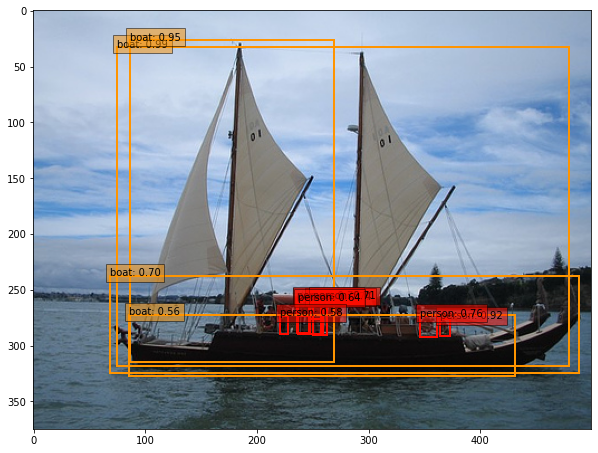

In [71]:
eval(my_net,240)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


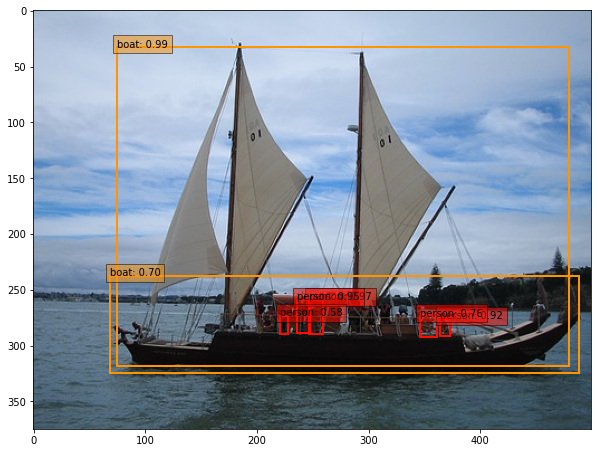

In [72]:
eval_nms(my_net,240)

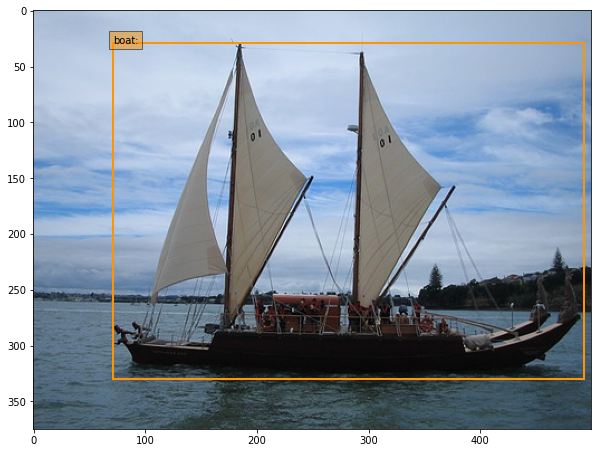

In [74]:
eval_actual(my_net,240)

References:

https://github.com/amdegroot/ssd.pytorch 

https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
